## (1) Import libraries

In [1]:
from pycaret.datasets import get_data
from pycaret.classification import *

from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Record version of key libraries
from importlib.metadata import version

print('pycaret==%s' % version('pycaret'))

pycaret==2.3.1


## (2) Get data

In [3]:
# Get a list of all pre-packaged data
# get_data('index')

# Select a pre-packaged data for testing
data = get_data('diabetes')

Number of times pregnant  \
0                         6   
1                         1   
2                         8   
3                         1   
4                         0   

   Plasma glucose concentration a 2 hours in an oral glucose tolerance test  \
0                                                148                          
1                                                 85                          
2                                                183                          
3                                                 89                          
4                                                137                          

   Diastolic blood pressure (mm Hg)  Triceps skin fold thickness (mm)  \
0                                72                                35   
1                                66                                29   
2                                64                                 0   
3                                66                                23   
4                                40                                35   

   2-Hour serum insulin (mu U/ml)  \
0                               0   
1                               0   
2                               0   
3                              94   
4                             168   

   Body mass index (weight in kg/(height in m)^2)  Diabetes pedigree function  \
0                                            33.6                       0.627   
1                                            26.6                       0.351   
2                                            23.3                       0.672   
3                                            28.1                       0.167   
4                                            43.1                       2.288   

   Age (years)  Class variable  
0           50               1  
1           31               0  
2           32               1  
3           21               0  
4           33               1

## (3) Setup pipeline

This step also includes data pre-processing steps such as normalisation and missing values imputation.

Logged data and profile are stored under `mlruns` folder.

In [4]:
# Setup upsampling method
ros = RandomOverSampler(sampling_strategy='not majority', random_state=6)

# Get relevant column names
numeric_cols = [
    'Number of times pregnant',
    'Plasma glucose concentration a 2 hours in an oral glucose tolerance test',
    'Diastolic blood pressure (mm Hg)', 
    'Triceps skin fold thickness (mm)',
    '2-Hour serum insulin (mu U/ml)',
    'Body mass index (weight in kg/(height in m)^2)'
]
categorical_cols = []
ignore_cols = []

# Setup core pycaret config
clf_setup = setup(
    data=data, 
    target='Class variable', 
    silent=True,
    numeric_features=numeric_cols,
    categorical_features=categorical_cols,
    ignore_features=ignore_cols,
    imputation_type='simple',
    numeric_imputation='median',
    normalize=True,
    normalize_method='minmax',
    fix_imbalance=True,
    fix_imbalance_method=ros,
    fold_strategy='stratifiedkfold',
    fold=10,
    n_jobs=-1,
    preprocess=True,
    session_id=6, 
    log_data=True,
    log_profile=True,
    log_experiment=True, 
    experiment_name='diabetes1')

# Add additional metrics for model evaluation
add_metric('balacc', 'Balanced Accuracy', balanced_accuracy_score, greater_is_better=True, target='pred')

# Retrieve and save processed data
X_data = get_config('X')
y_data = get_config('y')
y_data.name = 'Target variable'
comb_data = X_data.merge(y_data, left_index=True, right_index=True)
comb_data.to_csv('./processed_data.csv', index=False)

# data_processing_pipeline = get_config('prep_pipe')


## (4) Compare models

In [5]:
# Select a list of models of interest to be tested
# # To see all available models
# models()

# Pick logistic regression & ensemble models
chosen_model_types_list = ['lr'] + models(type='ensemble').index.tolist()

top3_models = compare_models(
    include = chosen_model_types_list, 
    n_select = 3,
    sort='Balanced Accuracy',
    errors='raise'
)

print(top3_models)

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=6, verbose=0,
                       warm_start=False), LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=6, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=6)

## (5) Tune models

In [6]:
# Tune top models

tuned_top3_models = [
    tune_model(
        i, 
        optimize='Balanced Accuracy',
        search_library='tune-sklearn',
        search_algorithm='hyperopt',
        choose_better=True
    ) 
    for i in top3_models]

print(tuned_top3_models)

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                       criterion='entropy', max_depth=5,
                       max_features=0.6311732042950683, max_leaf_nodes=None,
                       max_samples=None,
                       min_impurity_decrease=9.124812416452801e-08,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=6, min_weight_fraction_leaf=0.0,
                       n_estimators=120, n_jobs=-1, oob_score=False,
                       random_state=6, verbose=0, warm_start=False), LogisticRegression(C=6.68643136832486, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=6, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
  

## (6) Combine multiple models

In [7]:
# Blend top tuned models into a single voting classifier model

blended_model = blend_models(
    estimator_list = tuned_top3_models, 
    method = 'soft'
)

print(blended_model)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight={},
                                                     criterion='entropy',
                                                     max_depth=5,
                                                     max_features=0.6311732042950683,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=9.124812416452801e-08,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=5,
                                                     min_samples_split=6,
                                                     min_weight

## (7) Analyze model performance

In [8]:
# Make interactive standard diagnostic plots
evaluate_model(blended_model)

# plot_model(blended_model, plot='parameter')
# plot_model(blended_model, plot='manifold')
# plot_model(blended_model, plot='learning')
# plot_model(blended_model, plot='confusion_matrix')
# plot_model(blended_model, plot='class_report')
# # plot_model(blended_model, plot='feature')

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## (8) Interpret models

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


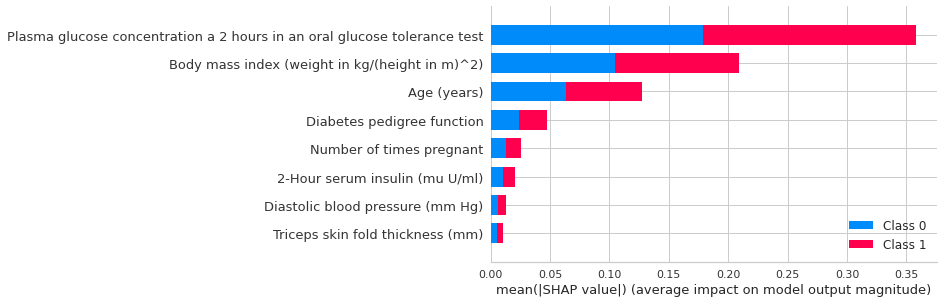

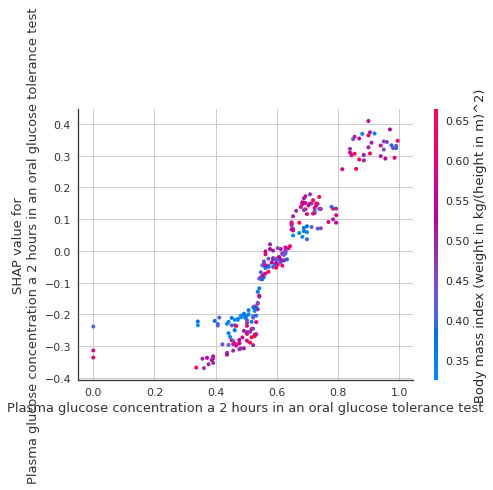

In [9]:
# Interpret model - only for tree-based models

interpret_model(tuned_top3_models[0], plot='summary')
interpret_model(tuned_top3_models[0], plot='correlation', feature='Plasma glucose concentration a 2 hours in an oral glucose tolerance test')
interpret_model(tuned_top3_models[0], plot='reason', observation=100)

## (9) Select best model automatically

In [10]:
# Select best model out of all models trained in current session

best_model = automl(optimize = 'Balanced Accuracy')

print(best_model)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight={},
                                                     criterion='entropy',
                                                     max_depth=5,
                                                     max_features=0.6311732042950683,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=9.124812416452801e-08,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=5,
                                                     min_samples_split=6,
                                                     min_weight

In [11]:
# Final check on performance of best model

compare_models(
    include = [best_model] + tuned_top3_models, 
    sort='Balanced Accuracy',
    errors='raise'
)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight={},
                                                     criterion='entropy',
                                                     max_depth=5,
                                                     max_features=0.6311732042950683,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=9.124812416452801e-08,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=5,
                                                     min_samples_split=6,
                                                     min_weight

## (10) Save best model

In [12]:
# Save model

save_model(best_model, model_name='best_model')
# best_model = load_model('best_model')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['Number of times '
                                                           'pregnant',
                                                           'Plasma glucose '
                                                           'concentration a 2 '
                                                           'hours in an oral '
                                                           'glucose tolerance '
                                                           'test',
                                                           'Diastolic blood '
                                                           'pressure (mm 